In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/ANNDL/Challenge2'

/content/drive/MyDrive/Colab Notebooks/ANNDL/Challenge2


### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [5]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Dataset Extraction

In [6]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [7]:
df_class = pd.DataFrame(y_train, columns=['class'])
df_class

,class
0,0
1,0
2,0
3,0
4,0
...,...
2424,11
2425,11
2426,11
2427,11


In [8]:
counts = df_class.value_counts(sort=False)
counts

class
0         34
1        123
2        270
3        381
4         62
5        153
6        313
7         68
8        120
9        777
10        77
11        51
dtype: int64

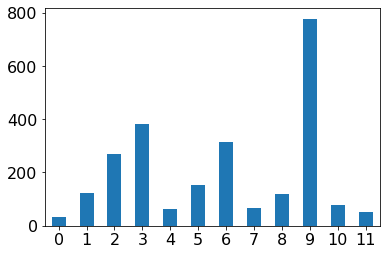

In [9]:
counts.plot(kind='bar', rot=0, use_index=False, xticks=counts.index.tolist())
#plt.savefig('counts.png')

### Robust rescaling

In [10]:
from sklearn import preprocessing

def robust(x_train, y_train, axis, stratify):

    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=True, random_state=seed, stratify=stratify)

    reshaped_X_train = np.reshape( X_train, (X_train.shape[0]*X_train.shape[1],X_train.shape[2]) )
    reshaped_X_test = np.reshape( X_test, (X_test.shape[0]*X_test.shape[1],X_test.shape[2]) )

    robust_scaler = preprocessing.RobustScaler()

    reshaped_X_train = robust_scaler.fit_transform(reshaped_X_train)
    reshaped_X_test = robust_scaler.transform(reshaped_X_test)

    X_train = np.reshape( reshaped_X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]) )
    X_test = np.reshape( reshaped_X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]) )

    Y_train = tfk.utils.to_categorical(y_train)
    Y_test = tfk.utils.to_categorical(y_test)

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = robust(x_train, y_train, (0,1), df_class['class'])

### Hyperparameters

In [11]:
input_shape = X_train.shape[1:]
num_classes = df_class['class'].nunique()
batch_size = 32
epochs = 200

### BiLSTM + conv net

In [12]:
def build_BiLSTM_classifier(input_shape, classes):
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)

    conv = tfkl.Conv1D(128, 3, padding='same', activation='relu')(bilstm) 
    conv = tfkl.MaxPool1D()(conv)
    conv = tfkl.Conv1D(64, 3, padding='same', activation='relu')(conv)
    conv = tfkl.MaxPool1D()(conv)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(conv)

    pool = tfkl.GlobalAveragePooling1D()(bilstm)
    dropout = tfkl.Dropout(.3, seed=seed)(pool)
    classifier = tfkl.Dense(32, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [13]:
model = build_BiLSTM_classifier(input_shape, num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           98432     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 64)            0     

### Fit

In [14]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size=batch_size,
    epochs = epochs,
    validation_data=(X_test, Y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
65/65 [==============================] - 18s 35ms/step - loss: 1.8945 - accuracy: 0.3987 - val_loss: 1.5142 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 2/200
65/65 [==============================] - 1s 13ms/step - loss: 1.4318 - accuracy: 0.5315 - val_loss: 1.3217 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 3/200
65/65 [==============================] - 1s 13ms/step - loss: 1.2742 - accuracy: 0.5736 - val_loss: 1.2157 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 4/200
65/65 [==============================] - 1s 13ms/step - loss: 1.1502 - accuracy: 0.6168 - val_loss: 1.1543 - val_accuracy: 0.6329 - lr: 0.0010
Epoch 5/200
65/65 [==============================] - 1s 13ms/step - loss: 1.0688 - accuracy: 0.6429 - val_loss: 1.1084 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 6/200
65/65 [==============================] - 1s 13ms/step - loss: 0.9837 - accuracy: 0.6667 - val_loss: 1.0459 - val_accuracy: 0.6356 - lr: 0.0010
Epoch 7/200
65/65 [==============================] - 1s 13ms/step - l

In [ ]:
model.save('Models/BiLSTM_final')

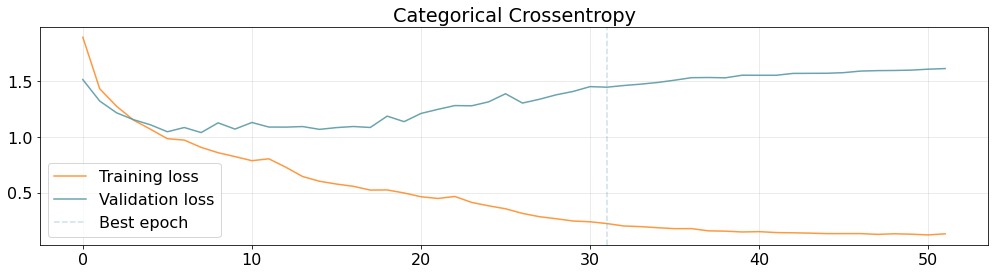

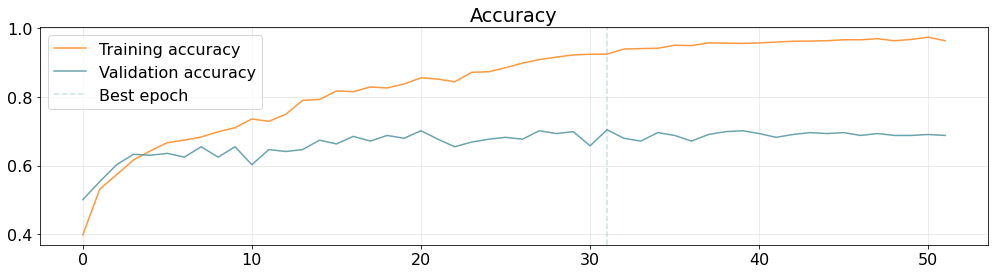

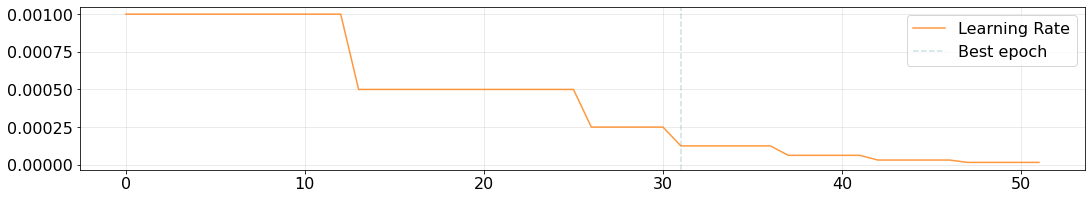

In [15]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()